In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, rossby_number, calc_tang_vel, find_directional_radii, nencioli, psi_params, fit_psi_params


#### New Grid for Nencioli

In [2]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


#### Interpolate to 1km grid, then apply Nencioli VG method

In [3]:
def interpolate_uv(u, v, X_new, Y_new, angle):
    x_new, y_new = X_new[:,0], Y_new[0,:]

    u_east = np.where(np.abs(u) > 1e30, np.nan, u).astype(float)
    v_north = np.where(np.abs(v) > 1e30, np.nan, v).astype(float)

    u_rot = v_north * np.sin(angle) + u_east * np.cos(angle)
    v_rot = v_north * np.cos(angle) - u_east * np.sin(angle)

    shape_new = X_new.shape
    new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

    interp_u = RegularGridInterpolator((x_grid, y_grid), u_rot,
                                       method='linear', bounds_error=False, fill_value=np.nan)
    interp_v = RegularGridInterpolator((x_grid, y_grid), v_rot,
                                       method='linear', bounds_error=False, fill_value=np.nan)

    u_new = interp_u(new_points).reshape(shape_new)
    v_new = interp_v(new_points).reshape(shape_new)

    return u_new, v_new


In [4]:
def dopioe_pipeliner(nxc, nyc, cyc, ut, vt, X_new, Y_new, r=30):

    R_grid = np.hypot(nxc - X_new, nyc - Y_new)
    ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

    # DOPIOE wont work if too close to boundary
    x_new = X_new[:, 0]
    y_new = Y_new[0, :]
    dx = np.max(np.diff(x_new))  # spacing in x-direction
    dy = np.max(np.diff(y_new))  # spacing in y-direction
    cell_size = np.max([dx, dy])        # average cell size in Euclidean units
    margin = int(np.ceil(r / cell_size)) 

    if (ic < margin or ic >= X_new.shape[0] - margin or
            jc < margin or jc >= X_new.shape[1] - margin):
        return np.nan, np.nan, np.nan, np.array([[np.nan, np.nan],
                                                [np.nan, np.nan]]), np.nan, np.nan, np.nan, np.nan

    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x_new - nxc) <= r
    x1 = x_new[x_mask]
    y1 = np.full_like(x1, y_new[jc])
    u1 = ut[x_mask, jc]
    v1 = vt[x_mask, jc]
    
    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y_new - nyc) <= r
    y2 = y_new[y_mask]
    x2 = np.full_like(y2, x_new[ic])
    u2 = ut[ic, y_mask]
    v2 = vt[ic, y_mask]
    
    xc, yc, w, Q, _, _, A0 = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)

    cyc_DOPIOE = 'CE' if w < 0 else 'AE'
    
    if (cyc_DOPIOE != cyc) or (np.hypot(nxc - xc, nyc - yc) > 50):
        return np.nan, np.nan, np.nan, np.array([[np.nan, np.nan],
                                                [np.nan, np.nan]]), np.nan, np.nan, np.nan, np.nan
    else:
        w *= 1e-3 # to s^-1

        radii = find_directional_radii(ut, vt, X_new, Y_new, xc, yc, calc_tang_vel)
        R = np.mean([radii['up'], radii['right'], radii['down'], radii['left']])

        q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]
        dx, dy = X_new - xc, Y_new - yc
        rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
        rho_search = np.sqrt(np.clip(rho2, 0, None))
        
        mask_outer = rho_search < min(R*1.75, 150)
        axi, ayi, aui, avi = X_new[mask_outer], Y_new[mask_outer], ut[mask_outer], vt[mask_outer]
        
        df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        Rc, psi0, A = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=300)

        if np.sign(A) != np.sign(w):
            Rc, psi0, A = np.nan, np.nan, A0
            return xc, yc, w, Q, Rc, psi0, A, R
        
    return xc, yc, w, Q, Rc, psi0, A, R


In [5]:
def build_nenc_dataframe(day, X_new, Y_new, lon_new, lat_new, angle):
    
    rows = []

    fnumber = 1461 + ((day - 1462) // 30)*30
    fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumber:05}.nc'
    dataset = nc.Dataset(fname)
    u_east = np.transpose(dataset['u_eastward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    v_north = np.transpose(dataset['v_northward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
    t = np.where(day==ocean_time)[0][0]
    if t.size != 0:
        u, v = u_east[:, :, t], v_north[:, :, t]
        u0, v0 = interpolate_uv(u, v, X_new, Y_new, angle)

        neddy = nencioli(u0.T, v0.T, X_new.T, Y_new.T, 4, 3)[2]
        # Sort so that the highest second-column value comes first
        neddy = neddy[neddy[:, 1].argsort()[::-1]]
        
        for idx, (nxc0, nyc0, cyc_indicator) in enumerate(neddy):
            cyc = 'CE' if cyc_indicator == 1 else 'AE'
            nic_idx, njc_idx = np.where((X_new == nxc0) & (Y_new == nyc0))
            if nic_idx.size:
                nic0, njc0 = nic_idx[0], njc_idx[0]
            else:
                nic0, njc0 = np.nan, np.nan

            xc, yc, w, Q, Rc, psi0, A, R = dopioe_pipeliner(nxc0, nyc0, cyc,
                                                          u0, v0, X_new, Y_new, r=30)
            
            rows.append({
                'Eddy_idx': idx,
                'Day': day,
                'Cyc': cyc,
                'nLon': lon_new[nic0, njc0],
                'nLat': lat_new[nic0, njc0],
                'nxc': nxc0,
                'nyc': nyc0,
                'nic': nic0,
                'njc': njc0,
                'xc': xc,
                'yc': yc,
                'w': w,
                'q11': Q[0,0],
                'q12': Q[1,0],
                'q22': Q[1,1],
                'Rc': Rc,
                'psi0': psi0,
                'A': A,
                'R': R
            })

    df_data_day = pd.DataFrame(rows)
    return df_data_day

start_day = 1462
num_days = 2 # last valid day 10650 # 9188 num of days then

dfs = []
for day in range(start_day, start_day + num_days + 1):
    dfs.append(build_nenc_dataframe(day, X_new, Y_new, lon_new, lat_new, angle))
    df_data = pd.concat(dfs, ignore_index=True)
    df_data.to_pickle(f"/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_data_{start_day}_cont.pkl")
    if day % 20 == 0:
        print(day)
        

In [6]:
df_data


,Eddy_idx,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,xc,yc,w,q11,q12,q22,Rc,psi0,A,R
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,830.505283,1516.358103,0.000017,0.720417,-0.098272,1.401490,98.027033,-40.680969,0.004234,24.781075
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.830407,1407.502025,0.000031,1.216814,-0.300862,0.896207,82.818108,-45.872592,0.006688,49.001445
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,928.354369,1356.372262,-0.000011,0.899317,-0.656994,1.591920,102.471873,40.739860,-0.003880,73.000954
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,505.897600,1353.012251,-0.000033,1.099922,-0.193920,0.943344,104.792967,71.469206,-0.006508,69.500036
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,753.364302,1284.532290,0.000022,1.292653,-0.367089,0.877850,101.823569,-43.652129,0.004210,64.751400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,35,1464,AE,150.340182,-38.445894,264.0,101.0,264,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,36,1464,CE,156.520455,-40.204643,829.0,99.0,829,99,832.330755,100.685630,-0.000017,0.656266,-0.452176,1.835329,30.268471,3.782634,-0.004129,20.019517
117,37,1464,CE,150.708513,-38.637268,301.0,92.0,301,92,301.268139,89.713287,-0.000018,1.523863,0.492799,0.815592,36.631074,6.239338,-0.004650,23.251986
118,38,1464,AE,151.070360,-39.085296,346.0,56.0,346,56,345.760953,55.175658,0.000035,1.454230,-0.321777,0.758849,35.369066,-10.814722,0.008645,23.250932


/scratch/pbs.7091950.kman.restech.unsw.edu.au/ipykernel_3621930/527722303.py:26: RuntimeWarning: invalid value encountered in sqrt
  rho_search = np.sqrt(data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2)


(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

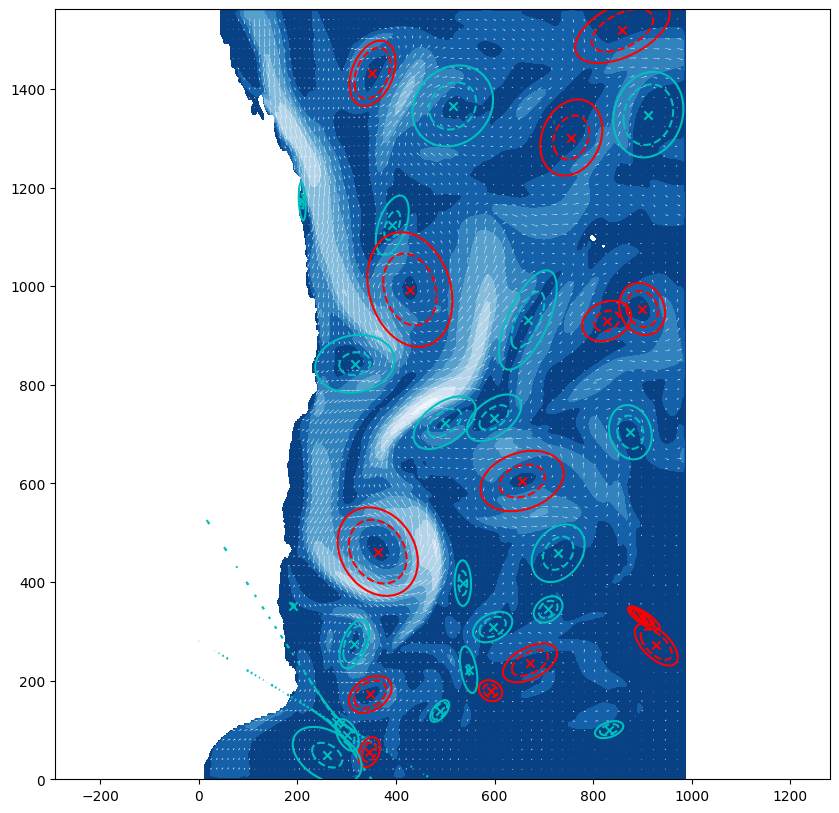

In [20]:
# day = 1464

# fnumber = 1461 + ((day - 1462) // 30)*30
# fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumber:05}.nc'
# dataset = nc.Dataset(fname)
# u_east = np.transpose(dataset['u_eastward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
# v_north = np.transpose(dataset['v_northward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
# ocean_time = dataset.variables['ocean_time'][:].data / 86400
# t = np.where(day==ocean_time)[0][0]
# u, v = u_east[:, :, t], v_north[:, :, t]
# u = np.where(np.abs(u) > 1e30, np.nan, u).astype(float)
# v = np.where(np.abs(v) > 1e30, np.nan, v).astype(float)

# df = df_data[df_data.Day==day]

# plt.figure(figsize=(10,10))
# plt.contourf(X_grid, Y_grid, np.hypot(u, v), cmap='Blues_r')
# spac = 4
# plt.quiver(X_grid[::spac,::spac], Y_grid[::spac,::spac], u[::spac,::spac], v[::spac,::spac],
#            cmap='Blues_r', color='w', width=.0005, scale=100)

# for k in range(len(df)):
#     data = df.iloc[k]
#     plt.scatter(data.xc, data.yc, marker='x', color='r' if data.Cyc=='AE' else 'c')
#     dx, dy = X_grid - data.xc, Y_grid - data.yc
#     rho_search = np.sqrt(data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2)

#     if data.Rc > 2*data.R:
#         RR = data.R
#     else:
#         RR = data.Rc
    
#     # plt.contour(X_grid, Y_grid, rho_search, levels=[RR/np.sqrt(2)], colors='r' if data.Cyc=='AE' else 'c')
#     plt.contour(X_grid, Y_grid, rho_search, levels=[data.Rc/np.sqrt(2)], colors='r' if data.Cyc=='AE' else 'c', linestyles='-')
#     plt.contour(X_grid, Y_grid, rho_search, levels=[data.R/np.sqrt(2)], colors='r' if data.Cyc=='AE' else 'c', linestyles='--')
# plt.axis('equal')
